# Algorithms for Big Data - Exercise 9
This lecture is focused on the Estimator usage in Keras library.

It shows you how to solve the classification problems in TensorFlow using Estimators. An Estimator is TensorFlow's high-level representation of a complete model, and it has been designed for easy scaling and asynchronous training. For more details see [this](https://www.tensorflow.org/guide/estimator).

You can download the dataset from this course [Github](https://github.com/rasvob/2020-21-ARD/tree/master/datasets)


[Open in Google colab](https://colab.research.google.com/github/rasvob/2020-21-ARD/blob/master/abd_09.ipynb)
[Download from Github](https://github.com/rasvob/2020-21-ARD/blob/master/abd_09.ipynb)

In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import matplotlib.pyplot as plt # plotting
import matplotlib.image as mpimg # images
import numpy as np #numpy
import seaborn as sns
import tensorflow as tf
# import tensorflow.compat.v2 as tf #use tensorflow v2 as a main 
import tensorflow.keras as keras # required for high level applications
from sklearn.model_selection import train_test_split # split for validation sets
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import normalize # normalization of the matrix
import scipy
import pandas as pd

tf.version.VERSION

'2.3.0'

In [4]:
import requests
from typing import List, Tuple

In [5]:
def show_history(history):
    plt.figure()
    for key in history.history.keys():
        plt.plot(history.epoch, history.history[key], label=key)
    plt.legend()
    plt.tight_layout()

In [6]:
sns.set_theme(style="darkgrid")


# We need to download the data first and take a look at the dataset

In [7]:
df = pd.read_csv('https://raw.githubusercontent.com/rasvob/2020-21-ARD/master/datasets/titanic_train.csv')

In [8]:
df.head()

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,1,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,1,female,35.0,1,0,53.1000,First,C,Southampton,n
4,0,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


# Each column has certain information about the specific passanger

In [9]:
txt_data = """Feature Name;Description
sex;Gender of passenger
age;Age of passenger
n_siblings_spouses;Number of siblings and partners aboard
parch;Number of parents and children aboard
fare;Fare passenger paid.
class;Passenger\'s class on ship
deck;Which deck passenger was on
embark_town;Which town passenger embarked from
alone;If passenger was alone"""
from io import StringIO
info = pd.read_csv(StringIO(txt_data), sep=';')
info

,Feature Name,Description
0,sex,Gender of passenger
1,age,Age of passenger
2,n_siblings_spouses,Number of siblings and partners aboard
3,parch,Number of parents and children aboard
4,fare,Fare passenger paid.
5,class,Passenger's class on ship
6,deck,Which deck passenger was on
7,embark_town,Which town passenger embarked from
8,alone,If passenger was alone


# Are there any missing values?

In [10]:
df.isna().sum()

survived              0
sex                   0
age                   0
n_siblings_spouses    0
parch                 0
fare                  0
class                 0
deck                  0
embark_town           0
alone                 0
dtype: int64

# Our goal is to predict if the person survived the cruise or not
We use the 'survived' column as our target. Other columns are meant as an input variables.

In [11]:
df.dtypes

survived                int64
sex                    object
age                   float64
n_siblings_spouses      int64
parch                   int64
fare                  float64
class                  object
deck                   object
embark_town            object
alone                  object
dtype: object

# We can start with a simple exploration analysis of the data to see what pieces of information may matter the most in the decision making process

<AxesSubplot:xlabel='survived', ylabel='count'>

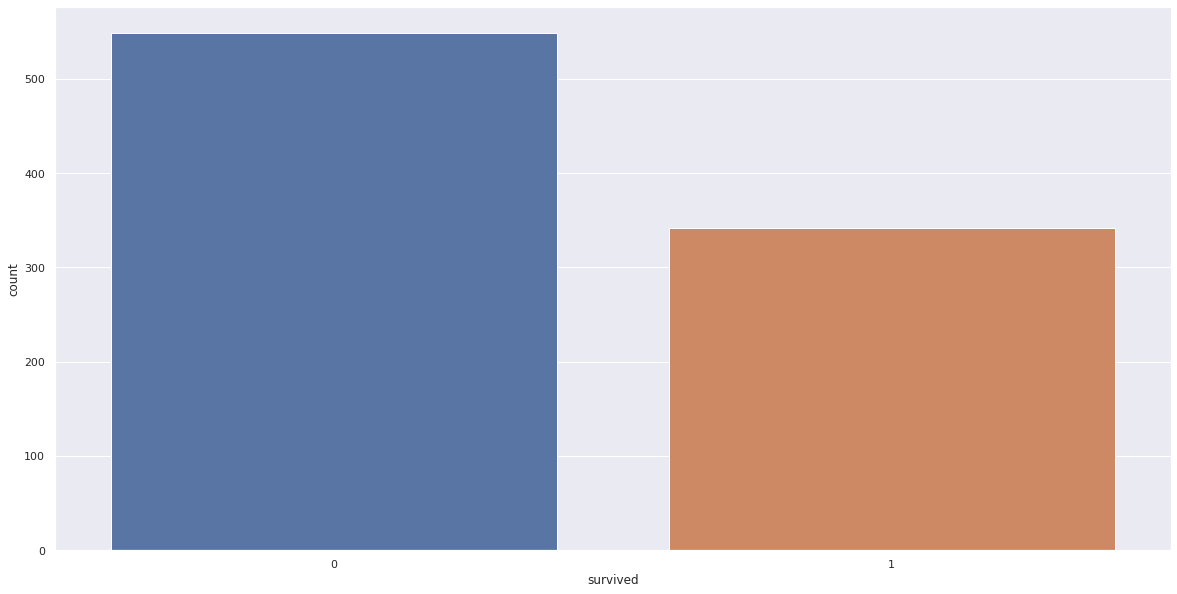

In [12]:
plt.figure(figsize=(20, 10))
sns.countplot(data=df, x='survived')

### We can see that females have aprox. 2 times higher chance to survive

<AxesSubplot:xlabel='sex', ylabel='count'>

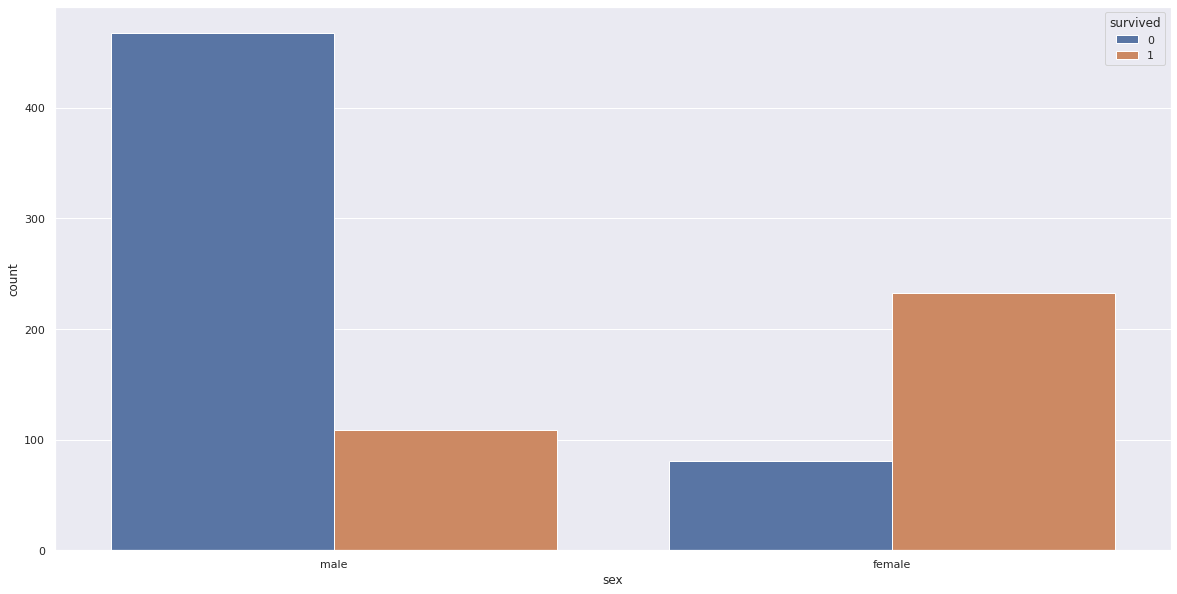

In [13]:
plt.figure(figsize=(20, 10))
sns.countplot(data=df, x='sex', hue='survived')

### Medians for are in both groups are really close to each other so we can say that age is not so significant feature

<AxesSubplot:xlabel='survived', ylabel='age'>

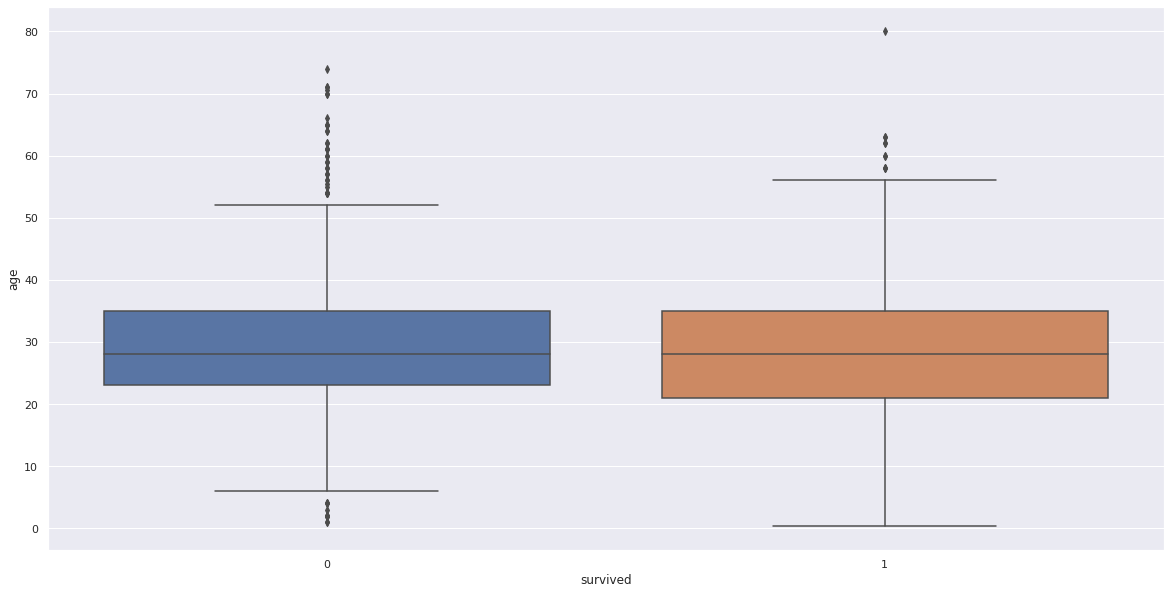

In [14]:
plt.figure(figsize=(20, 10))
sns.boxplot(data=df, y='age', x='survived')

### Not bein' alone on the other hand matters as we can see on the Number of siglings/spouses and parent/children counts

<AxesSubplot:xlabel='n_siblings_spouses', ylabel='count'>

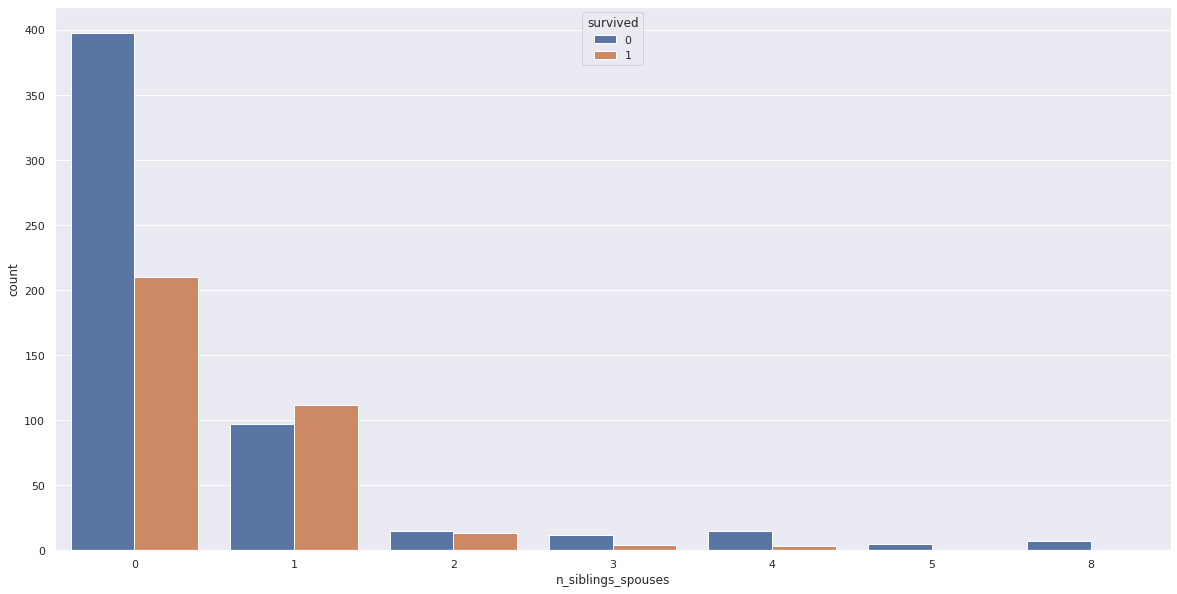

In [15]:
plt.figure(figsize=(20, 10))
sns.countplot(data=df, x='n_siblings_spouses', hue='survived')

<AxesSubplot:xlabel='parch', ylabel='count'>

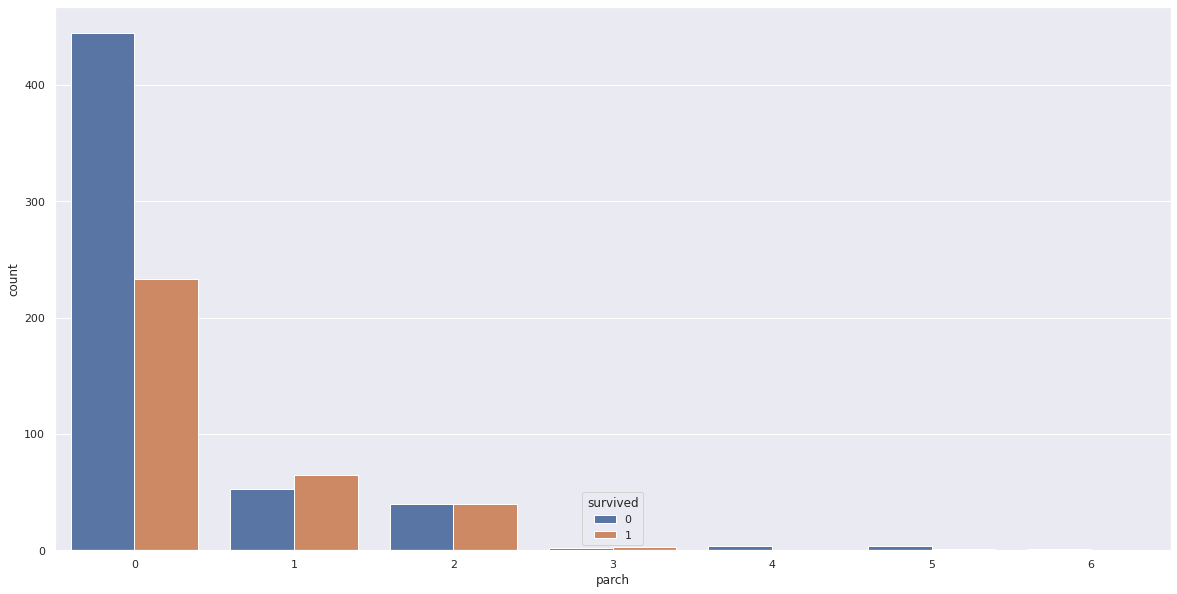

In [16]:
plt.figure(figsize=(20, 10))
sns.countplot(data=df, x='parch', hue='survived')

### Feature 'alone' is so-called interaction variable because if combines effect of both 'parch' and 'n_siblings_spouses' features

<AxesSubplot:xlabel='alone', ylabel='count'>

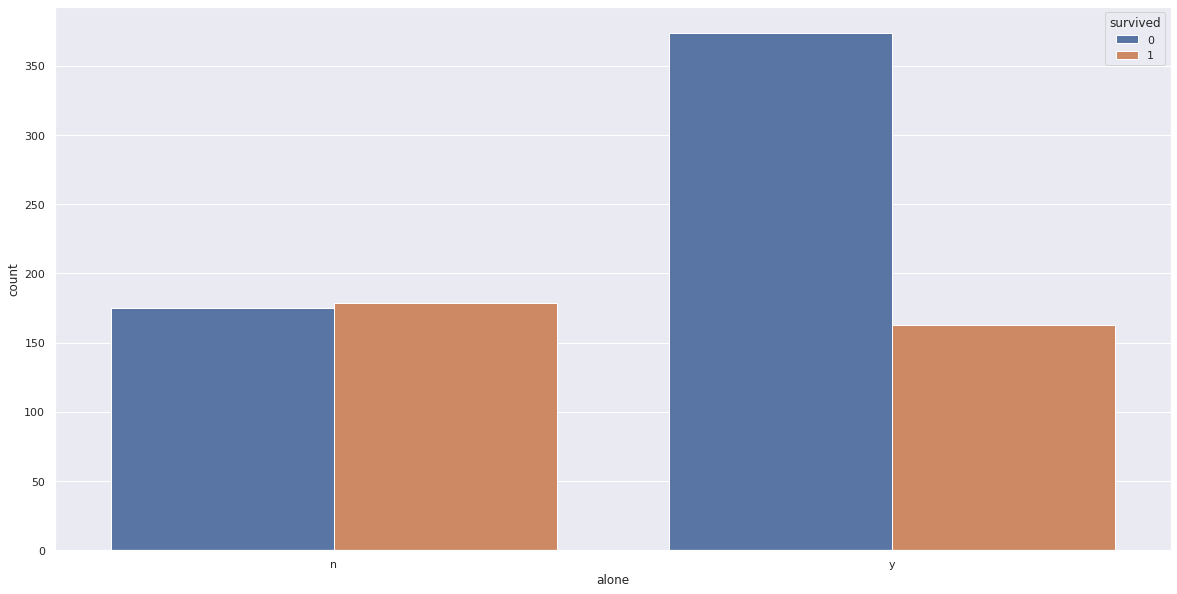

In [17]:
plt.figure(figsize=(20, 10))
sns.countplot(data=df, x='alone', hue='survived')

## Money definitely mattered as well, we can see that passangers with more expensive tickets were more likely to survive
The most obvious difference is in the thid and first class survival ratio.

<AxesSubplot:xlabel='survived', ylabel='fare'>

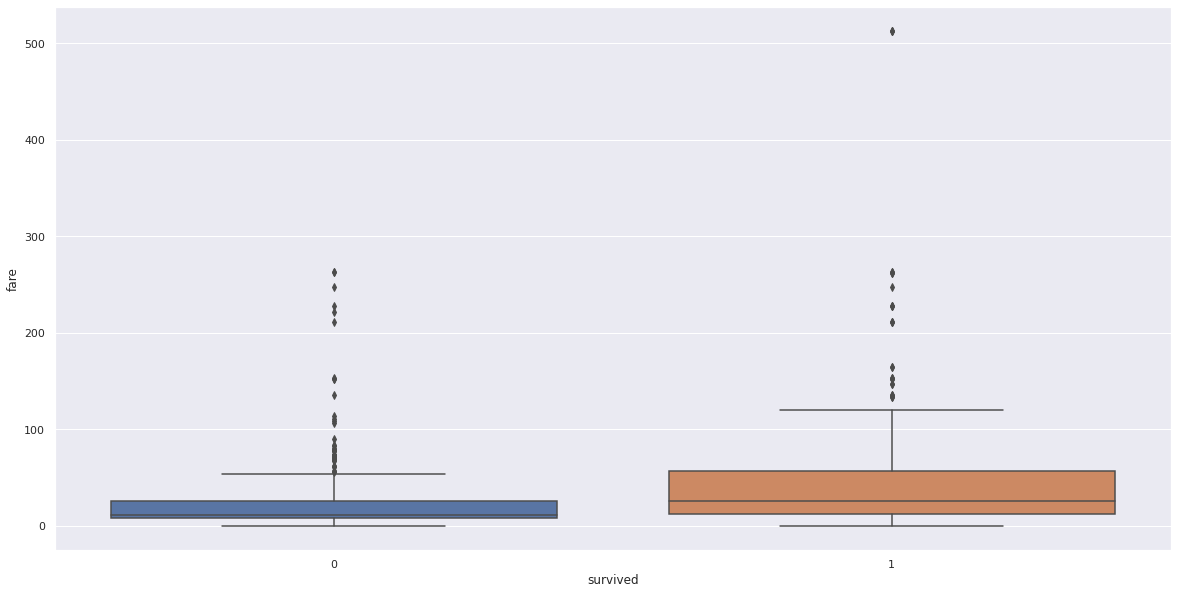

In [18]:
plt.figure(figsize=(20, 10))
sns.boxplot(data=df, y='fare', x='survived')

<AxesSubplot:xlabel='class', ylabel='count'>

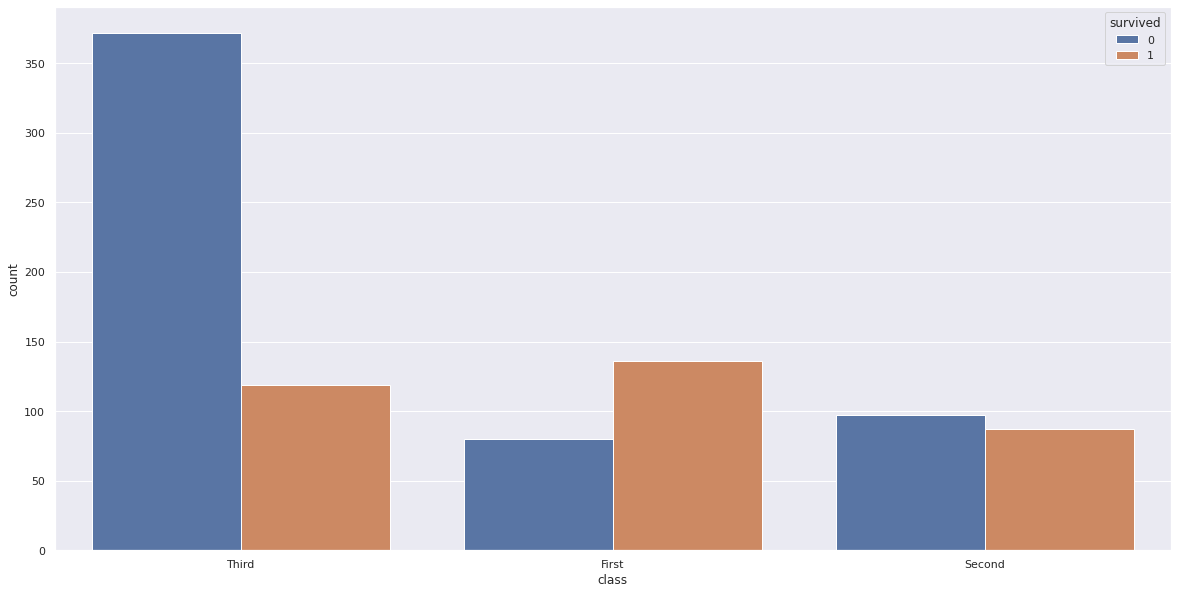

In [19]:
plt.figure(figsize=(20, 10))
sns.countplot(data=df, x='class', hue='survived')

<AxesSubplot:xlabel='deck', ylabel='count'>

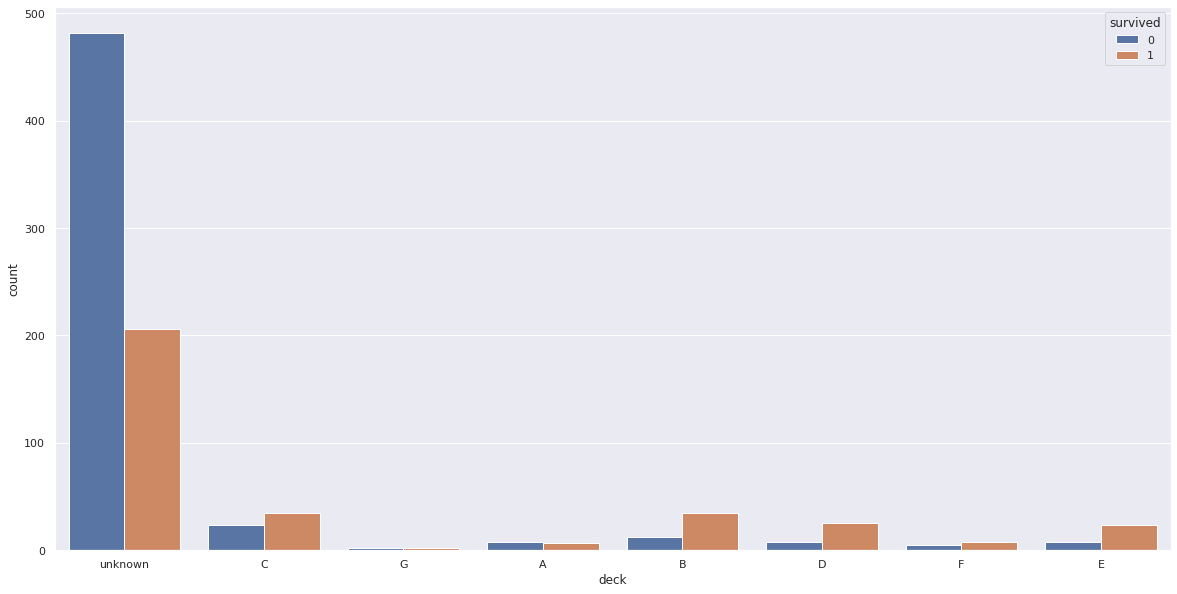

In [20]:
plt.figure(figsize=(20, 10))
sns.countplot(data=df, x='deck', hue='survived')

# Interesting thing is that the deck is mostly unknown for the passangers except the First class tickets.

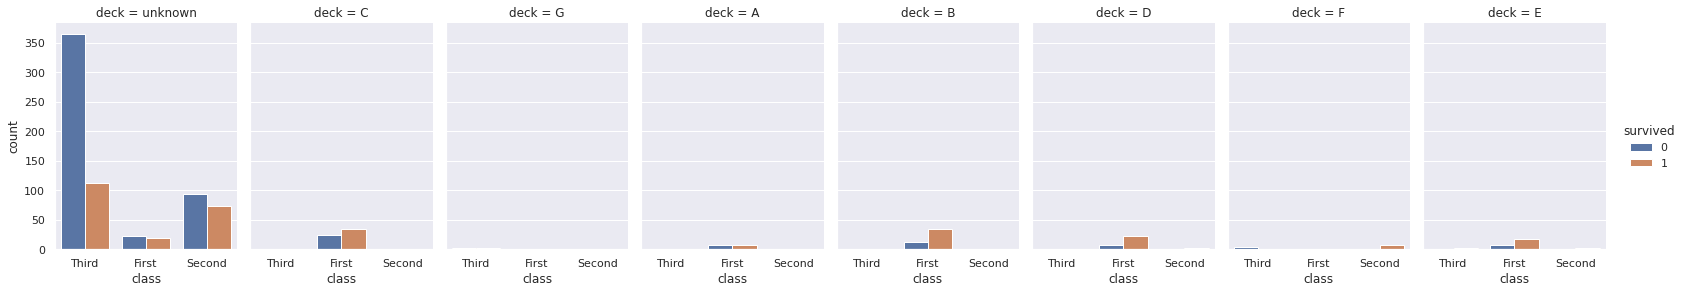

In [21]:
sns.catplot(data=df, x='class', hue='survived', col='deck', kind='count', height=4, aspect=.7)

### Passanger in the 2nd, and mostly in the 3rd, class were more likely to travel alone

<AxesSubplot:xlabel='class', ylabel='count'>

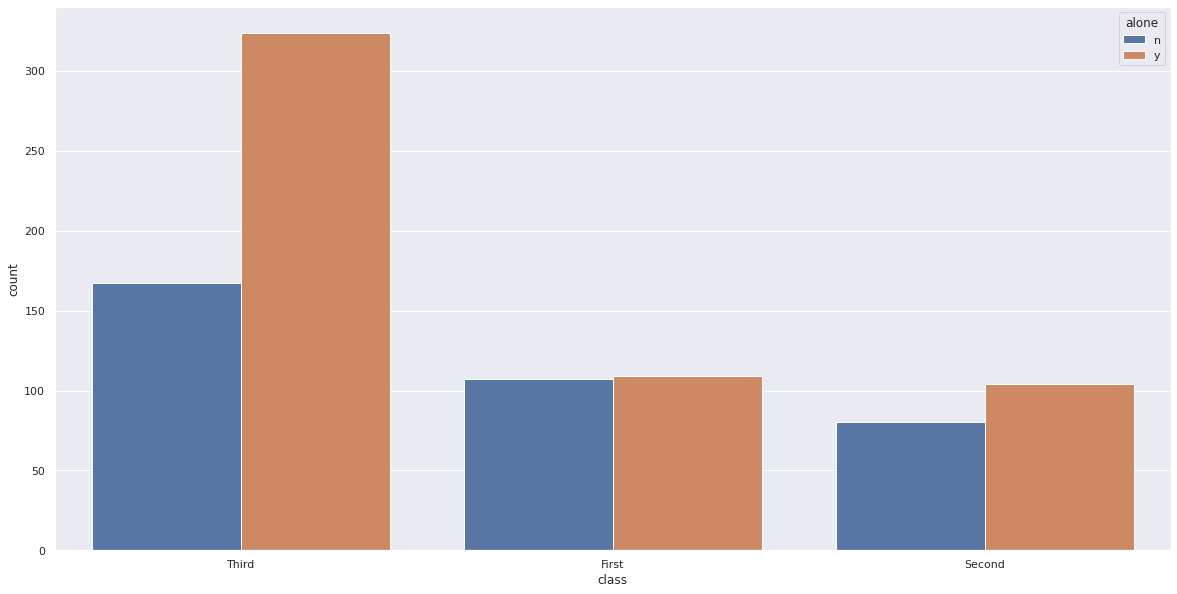

In [22]:
plt.figure(figsize=(20, 10))
sns.countplot(data=df, x='class', hue='alone')

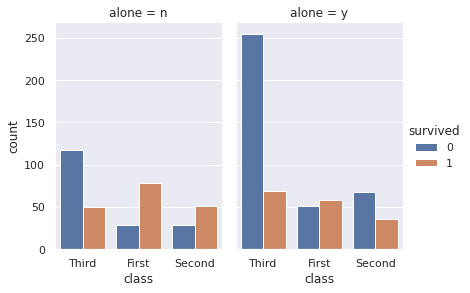

In [23]:
sns.catplot(data=df, x='class', hue='survived', col='alone', kind='count', height=4, aspect=.7)

### We can see that being the first class passanger with fellow people on board gave you significant advantage

<AxesSubplot:xlabel='class', ylabel='alone'>

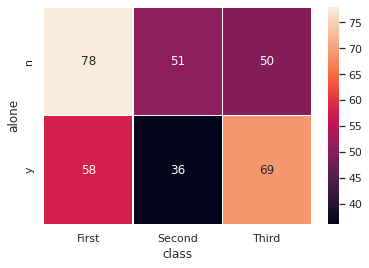

In [24]:
sns.heatmap(df.pivot_table(values='survived',index='alone', columns='class', aggfunc=np.sum), annot=True, fmt="d", linewidths=.5)

### Male passangers we more likely to travel alone; their survival change was not so high compared to the females

<AxesSubplot:xlabel='sex', ylabel='alone'>

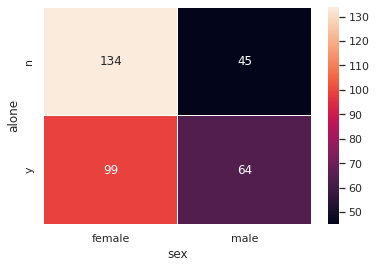

In [25]:
sns.heatmap(df.pivot_table(values='survived',index='alone', columns='sex', aggfunc=np.sum), annot=True, fmt="d", linewidths=.5)

## We can see that dataset contains only a few towns where the passangers embarked so there should be no issue with the vectorization of it

<AxesSubplot:xlabel='embark_town', ylabel='count'>

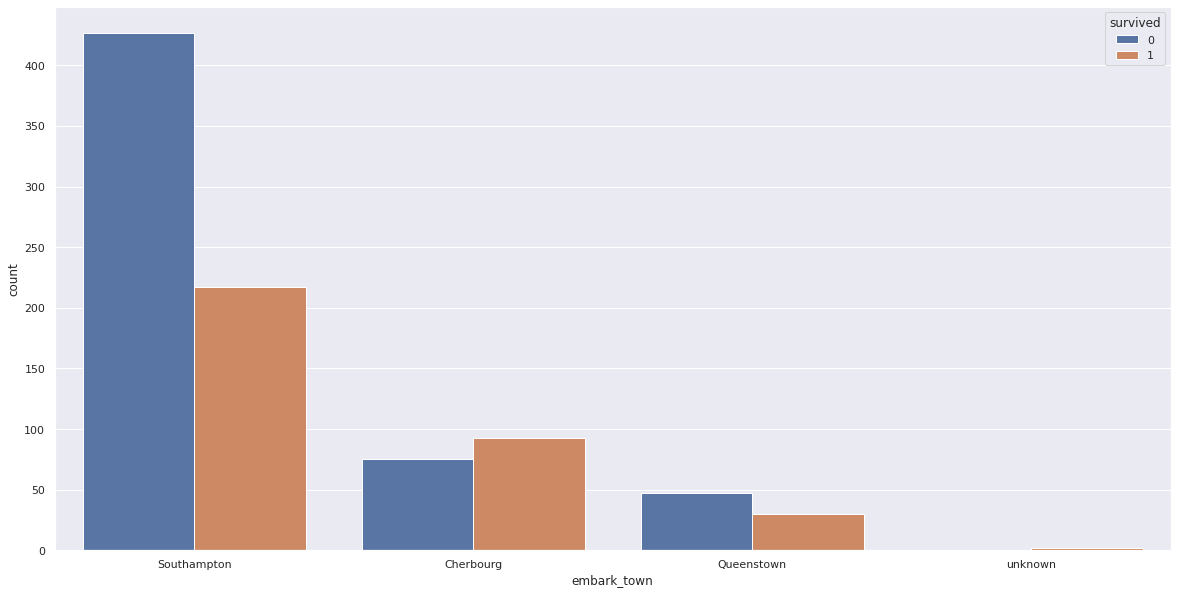

In [26]:
plt.figure(figsize=(20, 10))
sns.countplot(data=df, x='embark_town', hue='survived')

## Let's prepare the features and create simple classification model

Estimators use a system called feature columns to describe how the model should interpret each of the raw input features. An Estimator expects a vector of numeric inputs, and feature columns describe how the model should convert each feature.

Selecting and crafting the right set of feature columns is key to learning an effective model. A feature column can be either one of the raw inputs in the original features dict (a base feature column), or any new columns created using transformations defined over one or multiple base columns (a derived feature columns).

The linear estimator uses both numeric and categorical features. Feature columns work with all TensorFlow estimators and their purpose is to define the features used for modeling. Additionally, they provide some feature engineering capabilities like one-hot-encoding, normalization, and bucketization.

In [27]:
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  vocabulary = df[feature_name].unique()
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float64))

In [28]:
feature_columns

[VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4, 6), dtype=tf.int64, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Southampton', 'Cherbourg', 'Queenstown', 'unknown'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='alone', vocabulary_list=('n', 'y'), dtype=tf.st

## We need to define our own input_function

The input_function specifies how data is converted to a tf.data.Dataset that feeds the input pipeline in a streaming fashion. 

tf.data.Dataset can take in multiple sources such as a dataframe, a csv-formatted file, and more.

In [29]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
  def input_function():
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
    if shuffle:
      ds = ds.shuffle(1000)
    ds = ds.batch(batch_size).repeat(num_epochs)
    return ds
  return input_function

In [30]:
X, y = df.drop('survived', axis=1), df.survived

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

In [32]:
X_train.dtypes

sex                    object
age                   float64
n_siblings_spouses      int64
parch                   int64
fare                  float64
class                  object
deck                   object
embark_town            object
alone                  object
dtype: object

In [33]:
train_input_fn = make_input_fn(X_train, y_train)
test_input_fn = make_input_fn(X_test, y_test, num_epochs=1, shuffle=False)

## We take take look on the first batch of the data to see how it looks

In [34]:
ds = make_input_fn(X, y, batch_size=10)()
for feature_batch, label_batch in ds.take(1):
  print('Some feature keys:', list(feature_batch.keys()))
  print()
  print('A batch of class:', feature_batch['class'].numpy())
  print()
  print('A batch of alone feature:', feature_batch['alone'].numpy())
  print()
  print('A batch of Labels:', label_batch.numpy())

Some feature keys: ['sex', 'age', 'n_siblings_spouses', 'parch', 'fare', 'class', 'deck', 'embark_town', 'alone']

A batch of class: [b'Third' b'First' b'First' b'Second' b'Third' b'Third' b'Third' b'Third'
 b'Second' b'First']

A batch of alone feature: [b'y' b'y' b'n' b'y' b'y' b'y' b'n' b'y' b'y' b'n']

A batch of Labels: [0 1 1 1 1 0 0 0 0 1]


In [35]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)
linear_est.train(train_input_fn)
result = linear_est.evaluate(test_input_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpe6gw1y2m', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and 

In [36]:
result

{'accuracy': 0.82681566,
 'accuracy_baseline': 0.6089386,
 'auc': 0.8967234,
 'auc_precision_recall': 0.89049083,
 'average_loss': 0.38837025,
 'label/mean': 0.39106146,
 'loss': 0.3829169,
 'precision': 0.7826087,
 'prediction/mean': 0.39719173,
 'recall': 0.7714286,
 'global_step': 230}

## We usually want to get raw predictions from the model, either for further analysis or for other systemcomponents

In [50]:
predictions = linear_est.predict(test_input_fn)

In [51]:
predictions_list = list(predictions)
predictions_list[:3]

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpe6gw1y2m/model.ckpt-230
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


[{'logits': array([-2.482763], dtype=float32),
  'logistic': array([0.07707543], dtype=float32),
  'probabilities': array([0.9229246 , 0.07707542], dtype=float32),
  'class_ids': array([0]),
  'classes': array([b'0'], dtype=object),
  'all_class_ids': array([0, 1], dtype=int32),
  'all_classes': array([b'0', b'1'], dtype=object)},
 {'logits': array([3.2734919], dtype=float32),
  'logistic': array([0.9635081], dtype=float32),
  'probabilities': array([0.03649186, 0.9635081 ], dtype=float32),
  'class_ids': array([1]),
  'classes': array([b'1'], dtype=object),
  'all_class_ids': array([0, 1], dtype=int32),
  'all_classes': array([b'0', b'1'], dtype=object)},
 {'logits': array([-1.2034949], dtype=float32),
  'logistic': array([0.23085406], dtype=float32),
  'probabilities': array([0.76914597, 0.23085408], dtype=float32),
  'class_ids': array([0]),
  'classes': array([b'0'], dtype=object),
  'all_class_ids': array([0, 1], dtype=int32),
  'all_classes': array([b'0', b'1'], dtype=object)}]

## We are interested only in class_ids

In [56]:
y_pred = [x['class_ids'][0] for x  in predictions_list]

In [58]:
y_pred[:3]

[0, 1, 0]

## We can compute our own metrics which are missing from the Keras

In [59]:
f1_score(y_true=y_test, y_pred=y_pred)

0.7769784172661871

## Derived Feature Columns
Using each base feature column separately may not be enough to explain the data. For example, the correlation between gender and the label may be different for different gender. Therefore, if you only learn a single model weight for gender="Male" and gender="Female", you won't capture every age-gender combination (e.g. distinguishing between gender="Male" AND age="30" AND gender="Male" AND age="40").

To learn the differences between different feature combinations, you can add crossed feature columns to the model (you can also bucketize age column before the cross column):

In [60]:
age_x_gender = tf.feature_column.crossed_column(['age', 'sex'], hash_bucket_size=100)
derived_feature_columns = [age_x_gender]
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns+derived_feature_columns)
linear_est.train(train_input_fn)
result = linear_est.evaluate(test_input_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpdr_mqfl1', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. 

In [62]:
result

{'accuracy': 0.8324022,
 'accuracy_baseline': 0.6089386,
 'auc': 0.8917432,
 'auc_precision_recall': 0.8819931,
 'average_loss': 0.3898389,
 'label/mean': 0.39106146,
 'loss': 0.38638294,
 'precision': 0.8030303,
 'prediction/mean': 0.38786536,
 'recall': 0.75714284,
 'global_step': 230}

In [63]:
predictions = linear_est.predict(test_input_fn)
predictions_list = list(predictions)
y_pred = [x['class_ids'][0] for x  in predictions_list]

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpdr_mqfl1/model.ckpt-230
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [64]:
f1_score(y_true=y_test, y_pred=y_pred)

0.7794117647058824

# Task for the lecture
 - Choose either word or character level model
 - Choose another, at least one, HP book (it's on my Github, link at the top)
 - Preprocess it according to the first one
 - Merge the books together
 - Use pre-defined model from lecture or your own and train it for the long time (epochs > 50)
 - Experiment a little - try different batch sizes, optimimizers
 - Send me the Colab notebook with results and description of what you did and your final solution!